In [ ]:
pip install PyPortfolioOpt

In [ ]:
pip install yfinance

In [ ]:
pip install pulp

In [ ]:
pip install quandl

In [1]:
#equal risk contribution / risk parity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv("capstone_input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
rets=df.pct_change()
#rets = df[1:]
rets.tail()

,SBIN.NS,TATAMOTORS.NS,RELIANCE.NS,LT.NS,TATASTEEL.NS
Date,,,,,
2021-08-24,0.019780,0.010291,0.009873,0.015847,0.033857
2021-08-25,-0.003233,0.016440,0.008655,-0.007473,-0.010287
2021-08-26,-0.013213,-0.000352,0.012644,0.001223,-0.010898
2021-08-27,0.004139,0.005100,-0.001367,0.026539,0.006618
2021-08-30,0.024851,0.021697,0.019238,0.013430,0.040783


In [ ]:
cov = rets.cov()

# Equal-weights function
def equal_weights(rets):
    n = len(rets.columns)
    weights = pd.Series(1/n, index = rets.columns)
    return weights

# Portfolio Volatility
def pf_vol(weights, cov):
    return (weights.T @ cov @ weights)**0.5

# Risk-contributions for each asset towards the overall portfolio volatility
def risk_cont(weights, cov):
    pf_volatility = pf_vol(weights, cov) ** 2
    risk = cov@weights
    risk_contribution = np.multiply(risk, weights.T)/pf_volatility
    return risk_contribution

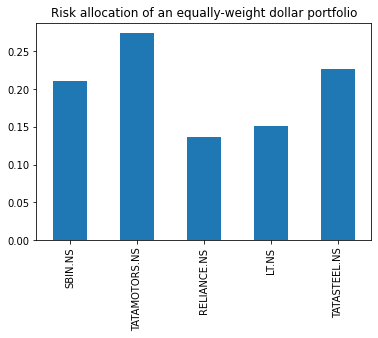

In [ ]:
# Risk-contributions for an equally-weighted portfolio
risk_cont(equal_weights(rets), cov).plot.bar(title = "Risk allocation of an equally-weight dollar portfolio")

In [ ]:
from scipy.optimize import minimize

# Find optimal dollar weights such that the risk-contributions meet a target contribution level, in this case being 1/n = 0.2 for each asset

def t_risk_cont(t_risk, cov):
    n = cov.shape[0]
    initial_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n
    weights_constraint = {'type': 'eq',
                         'fun': lambda weights: np.sum(weights) - 1}
    def msd(weights, t_risk, cov):
        contributions = risk_cont(weights, cov)
        return ((contributions - t_risk)**2).sum()
    
    weights = minimize(msd, initial_guess,
                       args=(t_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_constraint,),
                       bounds=bounds)
    return weights.x

def equal_risk_cont(cov):
    n = cov.shape[0]
    return t_risk_cont(np.repeat(1/n, n), cov)

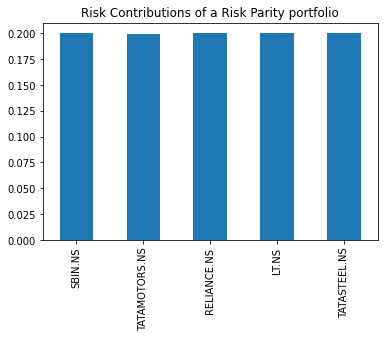

In [ ]:
# Risk-parity allocation levels for risk. We see that they are equal i.e 0.2

risk_cont(equal_risk_cont(cov), cov).plot.bar(title="Risk Contributions of a Risk Parity portfolio")

In [ ]:
# Find optimal weights to put in each industry based on the above risk-allocation levels above of 0.2

def sample_covariance(rets):
    return rets.cov()

def weight_rp(rets):
    est_cov = sample_covariance(rets)
    return equal_risk_cont(est_cov)

pd.DataFrame(weight_rp(rets) * 100, index = rets.columns, columns = ["Weight"])

,Weight
SBIN.NS,18.217026
TATAMOTORS.NS,14.781808
RELIANCE.NS,25.599156
LT.NS,24.162237
TATASTEEL.NS,17.239773
